In [66]:

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log
import numpy as np
import pandas as pd 
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.manifold import MDS
from statistics import mean

exec(compile(open(r"../nsimplices.py", encoding="utf8").read(), "nsimplices.py", 'exec'))

In [90]:
dataset_id = 'Baron'
df_gene = pd.read_csv(f"~/nSimplices/data/sce_full_{dataset_id}_scScope_log.csv", index_col=0, header=0)
df_gene = df_gene.iloc[823:]
print(df_gene.shape)
df_gene

(1063, 13357)


,X0610007P14Rik,X0610009B22Rik,X0610009E02Rik,X0610009L18Rik,X0610009O20Rik,X0610010F05Rik,X0610010K14Rik,X0610011F06Rik,X0610012G03Rik,X0610030E20Rik,...,Zw10,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
mouse2_lib1.final_cell_0002,1.622580,0.856702,0.517418,0.0,0.0,0.0,0.0,0.000000,0.000000,0.517418,...,0.517418,0.0,0.856702,0.000000,0.000000,0.000000,0.000000,0.856702,0.000000,0.000000
mouse2_lib1.final_cell_0003,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.907311,0.553210,0.000000,...,0.000000,0.0,1.375057,0.000000,0.000000,1.375057,0.000000,0.000000,0.907311,0.000000
mouse2_lib1.final_cell_0004,0.850549,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.850549,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.470711,0.000000,0.513103,0.513103
mouse2_lib1.final_cell_0005,0.000000,0.619066,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.619066,0.619066,0.619066,0.000000,0.000000,0.000000,0.000000
mouse2_lib1.final_cell_0006,0.000000,0.618157,0.000000,0.0,0.0,0.0,0.0,0.618157,0.618157,0.000000,...,0.000000,0.0,0.618157,0.000000,0.000000,0.618157,0.000000,0.618157,0.000000,0.997321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse2_lib3.final_cell_0391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mouse2_lib3.final_cell_0392,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,2.462117,0.000000,0.000000,0.000000,0.000000,0.000000,2.462117,0.000000
mouse2_lib3.final_cell_0393,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,1.923451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mouse2_lib3.final_cell_0394,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.036882,0.000000,0.000000,0.000000


In [91]:
# preprocess the dataset 
df_array = np.array(df_gene)
gene_meds = np.median(df_array, axis=0)
genes = df_gene.columns.values
gene_meds.shape

(13357,)

In [92]:
zipped = zip(gene_meds, genes)
    
# Sort the zipped array based on the values in the first array
sorted_zipped = sorted(zipped, key=lambda x: x[0], reverse=True)

# Unzip the sorted array
sorted_gene_meds, sorted_genes = zip(*sorted_zipped)

med_counts_dict = {}
for gene, med in zip(sorted_genes, sorted_gene_meds):
    med_counts_dict[gene] = med

In [142]:
# only consider the top 500 expressed genes
top_genes = sorted_genes[:500]
# print(top_genes)
df_gene_top500 = df_gene.loc[:, top_genes] 

# filter out cells with more than 100 zero counts
delete_indices = []
for index, row in df_gene_top500.iterrows():
    if list(row).count(0) > 300:
        delete_indices.append(index)

df_gene_top500 = df_gene_top500.drop(delete_indices)
print(df_gene_top500.shape)


(1028, 500)


In [143]:

### Run nSimplices method
feature_num = df_gene_top500.shape[1]
dim_start = 2
dim_end = 10
out_dis = pdist(df_gene_top500)
out_dis_sq = squareform(out_dis)
num_point = df_gene_top500.shape[0]

outlier_indices, subspace_dim, corr_dis_sq, corr_coord = nsimplices(out_dis_sq, feature_num, dim_start, dim_end, euc_coord=np.array(df_gene_top500.copy()), std_multi=2)

idx is: 218 height is: 27.470766297948423 thres is: 27.37731015953626
idx is: 223 height is: 27.941778352327965 thres is: 27.37731015953626
idx is: 229 height is: 28.215558092828005 thres is: 27.37731015953626
idx is: 247 height is: 27.64902391762218 thres is: 27.37731015953626
idx is: 251 height is: 27.598493491200557 thres is: 27.37731015953626
idx is: 254 height is: 27.535188412840373 thres is: 27.37731015953626
idx is: 257 height is: 28.143577751051694 thres is: 27.37731015953626
idx is: 265 height is: 28.00567953855564 thres is: 27.37731015953626
idx is: 266 height is: 27.838625779357166 thres is: 27.37731015953626
idx is: 269 height is: 28.341268029177698 thres is: 27.37731015953626
idx is: 272 height is: 29.13404116519876 thres is: 27.37731015953626
idx is: 276 height is: 27.77079106014334 thres is: 27.37731015953626
idx is: 291 height is: 30.17014734113867 thres is: 27.37731015953626
idx is: 293 height is: 28.832072332891393 thres is: 27.37731015953626
idx is: 295 height is: 28

In [144]:
print(outlier_indices)
len(outlier_indices)
# The 29 outliers deleted are: [  1   8   9  11  19  22  23  24  25  27  28  29  30  31  32  38  39  40
#  41  43  49  74 137 148 162 225 271 289 313]


[ 218  223  229  247  251  254  257  265  266  269  272  276  291  293
  295  296  298  301  306  307  308  309  518  539  564  570  571  584
  593  595  602  604  605  606  617  621  623  625  629  632  634  635
  636  637  640  642  644  645  646  647  648  835  875  888  895  913
  956  965  966  967  972  974  976  984  987  992  994 1002 1005 1007
 1012 1013 1014 1019 1021 1022 1025 1026 1027]


79

In [145]:
# # Run nSimplices for the second time to see if additional outliers are detected

# normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 
# feature_num = df_gene_top500.shape[1]
# df_gene_top500_second = df_gene_top500.iloc[normal_indices]
# dim_start = 3
# dim_end = 3
# out_dis = pdist(df_gene_top500_second)
# out_dis_sq = squareform(out_dis)
# num_point = df_gene_top500_second.shape[0]

# outlier_indices, subspace_dim, corr_dis_sq, corr_coord = nsimplices(out_dis_sq, feature_num, dim_start, dim_end, euc_coord=np.array(df_gene_top500.copy()), std_multi=3)
# print("the number of outliers in the second round is:", len(outlier_indices))

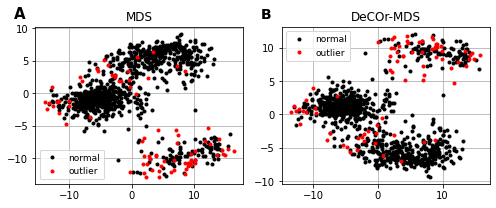

In [146]:
normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,0],Xe[normal_indices,1],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,0],Xe[outlier_indices,1],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(Xe[normal_indices,0],-Xe[normal_indices,1],'.', color='black', label="normal")
ax2.plot(Xe[outlier_indices,0],-Xe[outlier_indices,1],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_MDS_xy.pdf"
plt.savefig(fig_path)
plt.show()
plt.close()

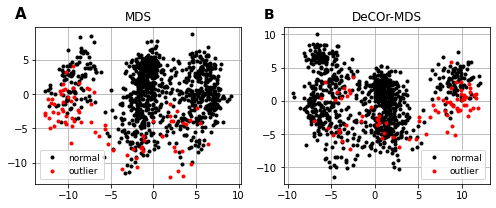

In [147]:


normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,1],Xe[normal_indices,2],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,1],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(-Xe[normal_indices,1],Xe[normal_indices,2],'.', color='black', label="normal")
ax2.plot(-Xe[outlier_indices,1],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_MDS_yz.pdf"
plt.savefig(fig_path)
plt.show()
plt.close()

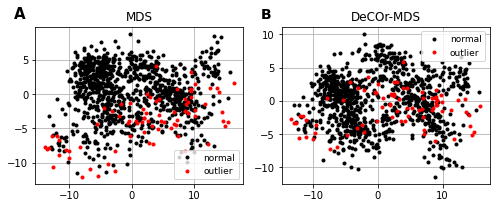

In [148]:
normal_indices=[i for i in range(num_point) if i not in outlier_indices] # list of normal points 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))



# plot original graphs with outliers added 
va, ve, Xe = cMDS(out_dis_sq)
ax1.plot(Xe[normal_indices,0],Xe[normal_indices,2],'.', color='black', label="normal")
ax1.plot(Xe[outlier_indices,0],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax1.legend(fontsize=9)
ax1.grid()
ax1.set_title("MDS")
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
        size=15, weight='bold')

# plot correct outliers 
va, ve, Xe = cMDS(corr_dis_sq)   
ax2.plot(Xe[normal_indices,0],Xe[normal_indices,2],'.', color='black', label="normal")
ax2.plot(Xe[outlier_indices,0],Xe[outlier_indices,2],'.',color='red', label="outlier")
ax2.legend(fontsize=9)
ax2.set_title("DeCOr-MDS")
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
        size=14, weight='bold')
ax2.grid()
plt.tight_layout()
fig_path =  f"../outputs/{dataset_id}_MDS_xz.pdf"
plt.savefig(fig_path)
plt.show()
plt.close()

In [180]:
# 3D plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio


outlier_inds = np.zeros(df_gene_top500.shape[0])
outlier_inds[outlier_indices] = 1

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
                    subplot_titles=('MDS',  'DeCOr-MDS'))

va, ve, Xe_MDS = cMDS(out_dis_sq)

# fig.add_trace(
#     go.Scatter3d(x=Xe[normal_indices, 0], y=[normal_indices, 1], z=Xe[normal_indices, 2], mode='markers', \
#                  marker=dict(size=3, color='yellow')),
#         row=1, col=1)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
    # eye = dict(x=0., y=2.5, z=0)
)


fig.add_trace(
    go.Scatter3d(x=-Xe_MDS[normal_indices, 0], y=Xe_MDS[normal_indices, 1], z=Xe_MDS[normal_indices, 2], mode='markers', name = "normal", marker=dict(size=3, color='blue')),
    row=1, col=1
)
# fig.update_layout(scene_camera=camera)


fig.add_trace(
    go.Scatter3d(x=-Xe_MDS[outlier_indices, 0], y=Xe_MDS[outlier_indices, 1], z=Xe_MDS[outlier_indices, 2], mode='markers', name = "outlier", marker=dict(size=3, color='red')),
    row=1, col=1
)
# fig.update_layout(scene_camera=camera)


va, ve, Xe_De = cMDS(corr_dis_sq)   

fig.add_trace(
    go.Scatter3d(x=-Xe_De[normal_indices, 0], y=Xe_De[normal_indices, 1], z=Xe_De[normal_indices, 2], mode='markers', name = "normal", marker=dict(size=3, color='blue')),
    row=1, col=2
)
# fig.update_layout(scene_camera=camera)


fig.add_trace(
    go.Scatter3d(x=-Xe_De[outlier_indices, 0], y=Xe_De[outlier_indices, 1], z=Xe_De[outlier_indices, 2], mode='markers', name = "outlier", marker=dict(size=3, color='red')),
    row=1, col=2
)
fig.update_layout(scene_camera=camera)


# fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()
fig_path = f"../outputs/{dataset_id}_MDS_3D.html"
fig.write_html(fig_path)

fig_path = f"../outputs/{dataset_id}_MDS_3D.pdf"
pio.write_image(fig, fig_path, width=1200, height=500)


In [169]:

""" 
Compute the average distance between the outlieres and the barycenter of regular points
"""

def centeroid(coords_list):
    """ 
    Computes the barycenter of a list of coordinates in coords_list
    """

    length = coords_list.shape[0]
    centroid = []
    for i in range(coords_list.shape[1]):
        centroid.append(np.sum(coords_list[:, i])/length)
    return np.array(centroid)

normal_centroid_MDS = centeroid(Xe_MDS[normal_indices, :]) # should only focus on the first inferred dimension coordinates
normal_centroid_MDS = normal_centroid_MDS[:subspace_dim]
outlier_Xe_MDS = Xe_MDS[outlier_indices, :subspace_dim]

    
# compute distance
total_distance = 0
for outlier_coord in outlier_Xe_MDS:
    total_distance += np.linalg.norm(outlier_coord-normal_centroid_MDS)
print("MDS average distance is:", total_distance/len(outlier_indices))

normal_centroid = centeroid(Xe_De[normal_indices, :]) # should only focus on the first inferred dimension coordinates
normal_centroid = normal_centroid[:subspace_dim]
outlier_Xe_De = Xe_De[outlier_indices, :subspace_dim]

# compute distance
total_distance = 0
for outlier_coord in outlier_Xe_De:
    total_distance += np.linalg.norm(outlier_coord-normal_centroid_MDS)
print("DeCOr-MDS average distance is:", total_distance/len(outlier_indices))


MDS average distance is: 12.598839661108695
DeCOr-MDS average distance is: 11.118454400280863


In [170]:
# examine the gene expression count profile

def count_outlier_percent(all_counts, outlier_counts):
    def find_outlier_bound(all_counts):
        # Calculate the first and third quartiles (Q1 and Q3)
        q1 = np.percentile(all_counts, 25)
        q3 = np.percentile(all_counts, 75)

        # Calculate the interquartile range (IQR)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        return lower_bound, upper_bound
    
    lower_bound, upper_bound = find_outlier_bound(all_counts)

    return sum((count > upper_bound or count < lower_bound) for count in outlier_counts)/len(outlier_counts)

In [171]:
print(len(top_genes))

500


In [172]:
box_plot_dict = {}
top_greater_genes = []
for gene in top_genes:
    outlier_counts = list(df_gene_top500.iloc[outlier_indices][gene])
    all_counts = list(df_gene_top500[gene])
    if count_outlier_percent(all_counts, outlier_counts) > 0.5:
        counts =  list(df_gene_top500[gene])
        box_plot_dict[gene] = counts
        top_greater_genes.append(gene)

print(len(top_greater_genes))

5


In [173]:
outlier_x = []
outlier_y = []
for index in outlier_indices:
    for gene in top_greater_genes:
        gene_index = top_greater_genes.index(gene)+1
        outlier_x.append(gene_index)
        outlier_gene_count = df_gene_top500.iloc[index][gene]
        outlier_y.append(outlier_gene_count)


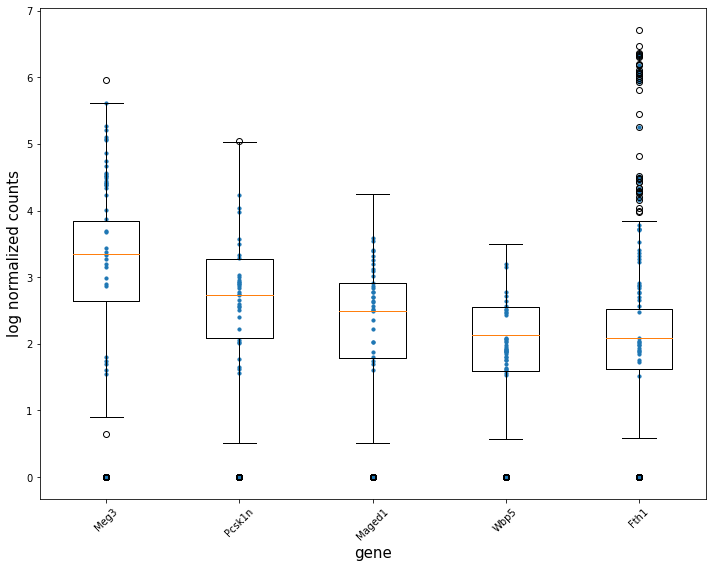

In [174]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
label_size = 15
ax.boxplot(box_plot_dict.values())
ax.set_xticklabels(box_plot_dict.keys())
plt.scatter(x=outlier_x, y=outlier_y, s=10)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("gene", fontsize=label_size)
plt.xticks(fontsize=10)
plt.ylabel("log normalized counts", fontsize=label_size)
plt.yticks(fontsize=10)
plt.tight_layout()
figpath = f"../outputs/{dataset_id}_gene_profile.pdf"
plt.savefig(figpath)
plt.show()



In [175]:
# compute the drop off rate for all cells, and compute the drop off rate for outliers

def compute_drop_out(df, outlier_indices):
    """ 
    @param Dataframe df: The dataframe containing all cells 
    @param list[int] outlier_indices: The outlier indices 

    Returns the dropout rates and the outlier drop out rates 
    """
    drop_outs = []
    outlier_drop_outs = []

    num_index = 0
    for _, row in df.iterrows():
        zero_rate = sum(i == 0 for i in list(row))/float(df.shape[1])
        drop_outs.append(zero_rate)
        if num_index in outlier_indices:
            outlier_drop_outs.append(zero_rate)
        num_index += 1
    
    return drop_outs, outlier_drop_outs

In [176]:
drop_offs, outlier_drop_offs = compute_drop_out(df_gene_top500, outlier_indices)

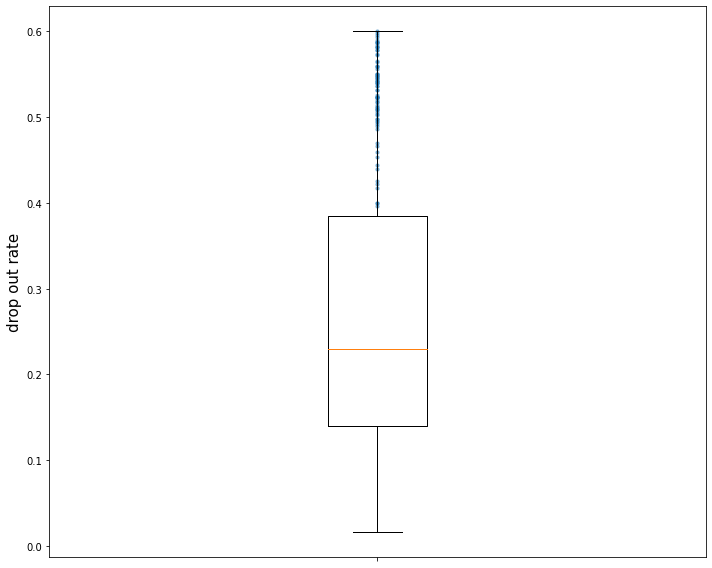

In [177]:
fig = plt.figure()
ax = plt.gca()
fig.set_figheight(8)
fig.set_figwidth(10)
label_size = 15
ax.boxplot(drop_offs)
ax.set_xticklabels([])

plt.scatter(x=[1]*len(outlier_drop_offs), y=outlier_drop_offs, s=10, alpha=0.5)
# ax.tick_params(axis='x', rotation=45)
# plt.xlabel("gene", fontsize=label_size)
# plt.xticks(fontsize=10)
plt.ylabel("drop out rate", fontsize=label_size)
plt.yticks(fontsize=10)
plt.tight_layout()
figpath = f"../outputs/{dataset_id}_dropout_box_top500.pdf"
plt.savefig(figpath)
plt.show()


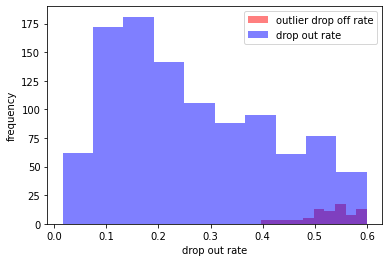

In [178]:
plt.hist(outlier_drop_offs, label='outlier drop off rate', color='red', alpha=0.5)
plt.hist(drop_offs, label="drop out rate", color='blue', alpha=0.5)
plt.xlabel('drop out rate')
plt.ylabel('frequency')
plt.legend()
fig_path = f"../outputs/{dataset_id}_dropout_hist_top500.pdf"
plt.savefig(fig_path)
plt.show()


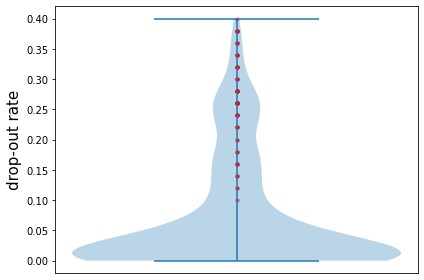

In [179]:
# compute the drop off rate for the top 50 highly expressed genes
top_50_genes = sorted_genes[:50]
df_gene_top50 = df_gene_top500.loc[:, top_50_genes] 

drop_offs, outlier_drop_offs = compute_drop_out(df_gene_top50, outlier_indices)

fig = plt.figure()
ax = plt.gca()
# fig.set_figheight(8)
# fig.set_figwidth(10)
label_size = 15
ax.violinplot(drop_offs)
ax.set_xticklabels([])

plt.scatter(x=[1]*len(outlier_drop_offs), y=outlier_drop_offs, s=10, alpha=0.5, c='red')
plt.ylabel("drop-out rate", fontsize=label_size)
plt.yticks(fontsize=10)
# plt.title('Dropout rates for the top 50 highly expressed genes')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
figpath = f"../outputs/{dataset_id}_dropout_violin_top50.pdf"
plt.savefig(figpath)
plt.show()


In [ ]:
def determine_rank_dropoff(df, sorted_genes):
    """ 
    Deterine the gene rank for the cell counts 

    @param Dataframe df: The dataframe consisting of gene counts, with gene names as the header
    @param list[str] sorted genes: gene names in sorted order
    
    Returns:
        - a list of ranks for the genes in df with zero counts
    """
    gene_names = list(df.columns.values)
    ranks_vec = []
    for _, row in df.iterrows():
        ranks = []
        for i, count in enumerate(list(row)):
            if count == 0:
                gene_name = gene_names[i]
                ranks.append(sorted_genes.index(gene_name))
        ranks_vec.append(ranks)
    return ranks_vec


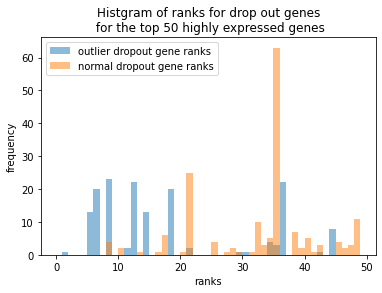

In [ ]:
outlier_df = df_gene_top50.iloc[outlier_indices]

normal_df = df_gene_top50.iloc[normal_indices]

outlier_ranks = determine_rank_dropoff(outlier_df, sorted_genes)
outlier_ranks_flat = [item for sublist in outlier_ranks for item in sublist]

normal_ranks = determine_rank_dropoff(normal_df, sorted_genes)
normal_ranks_flat = [item for sublist in normal_ranks for item in sublist]

plt.hist(outlier_ranks_flat, label='outlier dropout gene ranks', alpha=0.5, bins=np.arange(0, 50, 1))
plt.hist(normal_ranks_flat, label='normal dropout gene ranks', alpha=0.5, bins=np.arange(0, 50, 1))
plt.ylabel('frequency')
plt.xlabel('ranks')
plt.title('Histgram of ranks for drop out genes\n for the top 50 highly expressed genes')
plt.legend()
fig_path = f"../outputs/{dataset_id}_dropout_ranks_top50.pdf"
plt.savefig(fig_path)
plt.show()


In [ ]:
print(normal_ranks)
print(outlier_ranks)

[[], [34], [], [], [], [35], [], [21], [], [], [], [], [], [8, 34, 35], [], [], [], [], [25], [8, 21, 34], [], [], [34], [42], [], [21, 35], [], [], [35], [], [], [], [], [32, 38, 39], [21, 35], [], [38, 40], [], [], [], [], [35, 46], [], [], [], [], [], [], [], [], [35], [35], [35], [], [17, 35], [], [35], [17, 21, 40], [], [], [], [], [], [49], [], [], [21, 35], [], [], [], [], [35], [33], [], [], [35], [], [21, 35], [], [21, 35], [], [38, 48], [], [], [33], [], [], [35], [], [], [32], [], [], [], [13, 38], [], [], [], [], [], [21], [21, 35], [], [], [], [], [], [35], [32], [35, 48], [10], [], [], [], [40, 42], [], [], [], [49], [], [], [35], [], [], [35], [32], [], [], [], [], [], [], [28, 35], [47], [], [], [], [], [32], [], [], [21], [], [], [], [21], [35], [], [21], [], [], [], [], [35], [], [35], [], [], [21], [], [], [], [], [], [21, 38], [34], [17, 21, 35, 38], [], [21, 35], [32], [], [29], [], [], [], [], [38], [], [], [20, 25], [35], [], [35], [], [21, 35], [35], [], [35], [

In [ ]:
# perform pairwise T-test for all pairs between outliers and normal points
outlier_total_counts = np.array(outlier_df).sum(axis=1)
normal_total_counts = np.array(normal_df).sum(axis=1)

pairs = []
for outlier_total_count in outlier_total_counts:
    for normal_total_count in normal_total_counts:
        pairs.append(normal_total_count-outlier_total_count)

num_pair = len(outlier_total_counts)*len(normal_total_counts)
degree = num_pair-1
 
est_mean = sum(pairs)/num_pair

# calculate standard deviation

est_sd = np.sqrt(sum([(pair-est_mean)**2 for pair in pairs])/degree)

# calculate the standard error of the mean
est_se = est_sd/np.sqrt(num_pair)

# calculate t-value
t_value = est_mean/est_se

print("degree of freedom:", degree, "t_value is:", t_value)

degree of freedom: 9569 t_value is: 105.81678660378093


In [ ]:
# the t-value 105.81678660378093 is greater than the critical t value of degree 9569 (1.960-1.960), the null hypothesis is rejected.
# Significant level = 0.05
# The total counts from outlier group is significantly different from the total counts from the normal group.

In [ ]:
# Run nSimplices for the second time to see if additional outliers are detected

feature_num = df_gene_top500.shape[1]
df_gene_top500_second = df_gene_top500.iloc[normal_indices]
dim_start = 3
dim_end = 3
out_dis = pdist(df_gene_top500_second)
out_dis_sq = squareform(out_dis)
num_point = df_gene_top500_second.shape[0]

outlier_indices, subspace_dim, corr_dis_sq, corr_coord = nsimplices(out_dis_sq, feature_num, dim_start, dim_end, euc_coord=np.array(df_gene_top500.copy()), std_multi=6)
print("the number of outliers in the second round is:", len(outlier_indices))